### **Section 1 – Data exploration and pre-processing**

Load the dataset, manipulating the data and answering the following questions.



In [2]:
 from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install pyarrow
!pip install matplotlib_inline
#all the necessary libaries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
from collections import Counter
from wordcloud import WordCloud
data = pd.read_parquet('/content/drive/My Drive/ML_project/ssh_attacks.parquet')
data.head()

,session_id,full_session,first_timestamp,Set_Fingerprint
0,0,enable ; system ; shell ; sh ; cat /proc/mount...,2019-06-04 09:45:11.151186+00:00,"[Defense Evasion, Discovery]"
1,1,enable ; system ; shell ; sh ; cat /proc/mount...,2019-06-04 09:45:50.396610+00:00,"[Defense Evasion, Discovery]"
2,2,enable ; system ; shell ; sh ; cat /proc/mount...,2019-06-04 09:54:41.863315+00:00,"[Defense Evasion, Discovery]"
3,3,enable ; system ; shell ; sh ; cat /proc/mount...,2019-06-04 10:22:14.623875+00:00,"[Defense Evasion, Discovery]"
4,4,enable ; system ; shell ; sh ; cat /proc/mount...,2019-06-04 10:37:19.725874+00:00,"[Defense Evasion, Discovery]"


### **1. When are the attacks performed? Analyze the temporal series.**

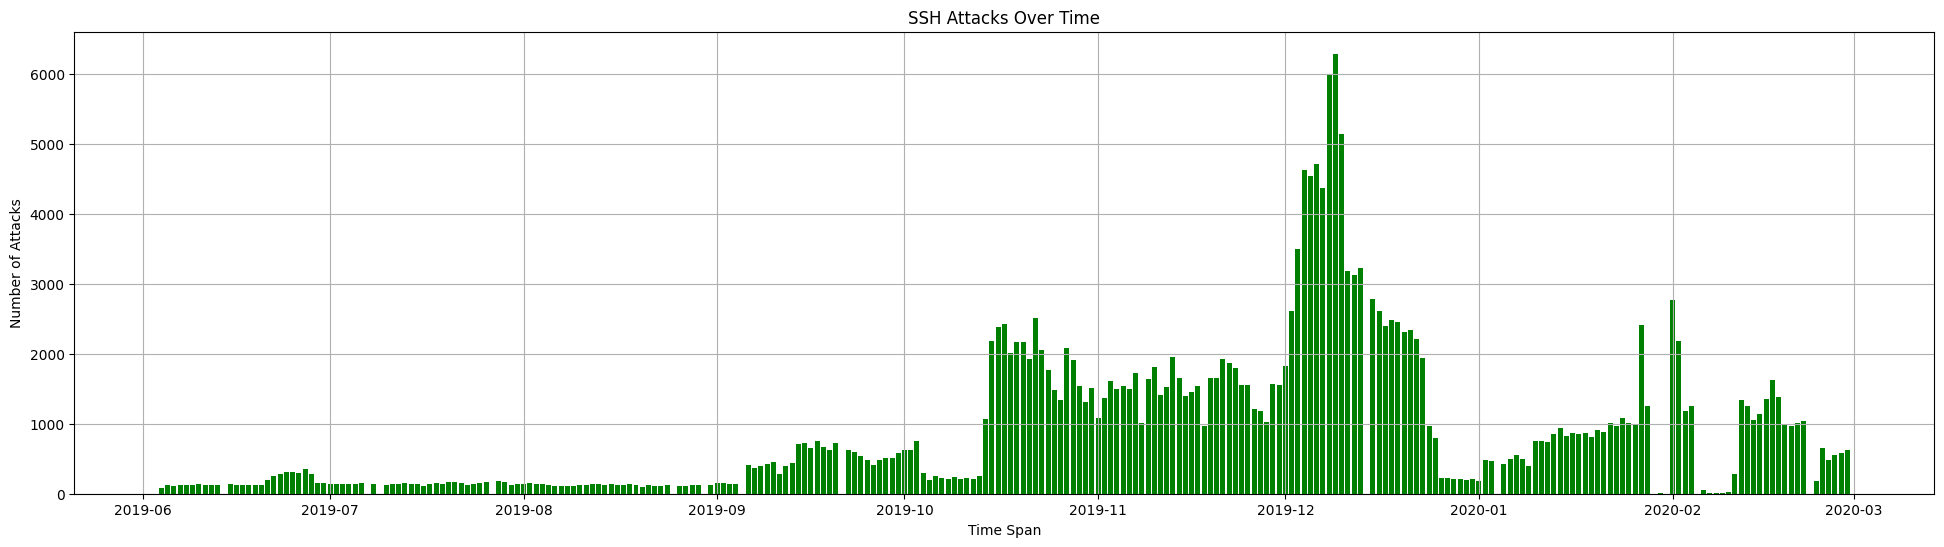

In [ ]:
## Daily Attacks
data['first_timestamp'] = pd.to_datetime(data['first_timestamp']) #convert dataframe to datetime
df_resampled = data.groupby(pd.Grouper(key='first_timestamp', freq='D')).size().reset_index(name='Attacks_D') #using 'pd.grouper' specify the frequency as hourly ('H'), daily ('D') or monthly ('m')



#plot number of attacks per time span
plt.figure(figsize=(24, 6))
plt.bar(df_resampled['first_timestamp'], df_resampled['Attacks_D'] , color='green')
plt.title('SSH Attacks Over Time')
plt.xlabel('Time Span')
plt.ylabel('Number of Attacks')
plt.grid()
plt.savefig('/content/drive/My Drive/ML_project/ssh_attacks_over_time.png')
plt.show()


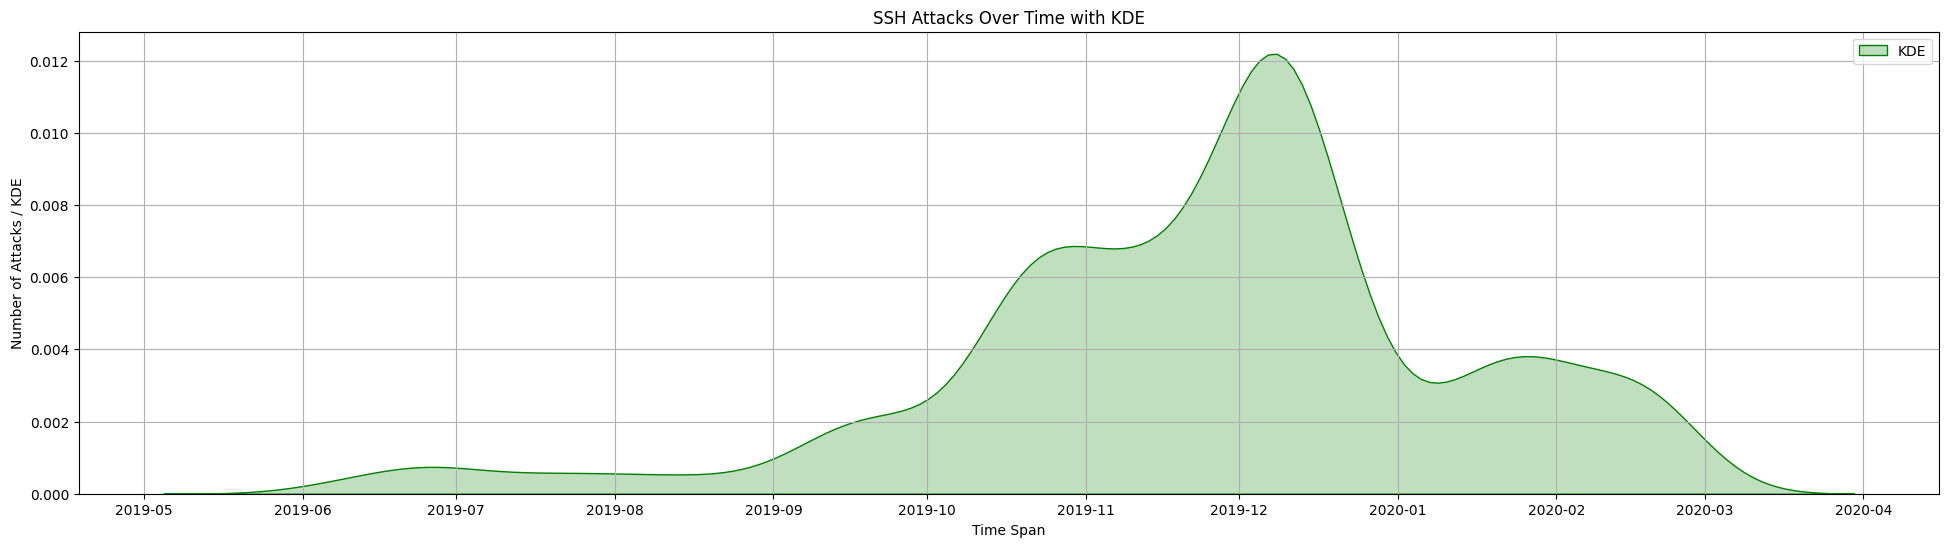

In [ ]:
#for better visualization, KDE is also plotted
data['first_timestamp'] = pd.to_datetime(data['first_timestamp'])
data['date_column'] = data['first_timestamp'].dt.date
data['date_column'] = pd.to_datetime(data['date_column'])


# Plot the temporal series with KDE
plt.figure(figsize=(24, 6))

# KDE plot
sns.kdeplot(data['date_column'], color='green', label='KDE', bw_method=0.2, fill=True)


plt.title('SSH Attacks Over Time with KDE')
plt.xlabel('Time Span')
plt.ylabel('Number of Attacks / KDE')
plt.legend()
plt.grid()
plt.savefig('/content/drive/My Drive/ML_project/KDE.png')
plt.show()


plotting the Kernel Density Estimate (KDE) along with the temporal analysis can provide additional insights into the distribution of attacks over time. The KDE plot shows the probability density of the data at different values, offering a smoothed representation of the temporal distribution.

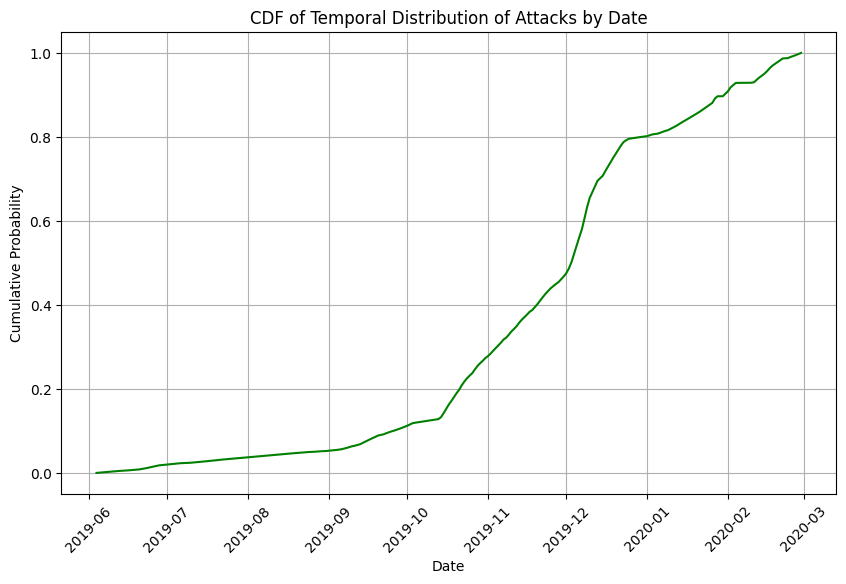

In [ ]:
#CDF plotting for better analysing attacks
daily_attacks = data.groupby('date_column').size().sort_index()

cdf = daily_attacks.cumsum() / daily_attacks.sum() # comsum() used to compute the cumulative sum of elements along a specific axis in a DataFrame or Series

plt.figure(figsize=(10, 6))
plt.plot(cdf.index.to_numpy(), cdf.values, linestyle='-', color='green')
plt.title('CDF of Temporal Distribution of Attacks by Date')
plt.xlabel('Date')
plt.ylabel('Cumulative Probability')
plt.xticks(rotation=45)
plt.grid()
plt.savefig('/content/drive/My Drive/ML_project/CDF.png')
plt.show()


plotting the Cumulative Distribution Function (CDF) is another valuable approach for understanding the temporal distribution of attacks. The CDF illustrates the probability that a random variable takes a value less than or equal to a given point.

### **2. Extract features from the attack sessions. How does the empirical distribution of the number of characters in each session look like?How is the distribution of the number of word per session**

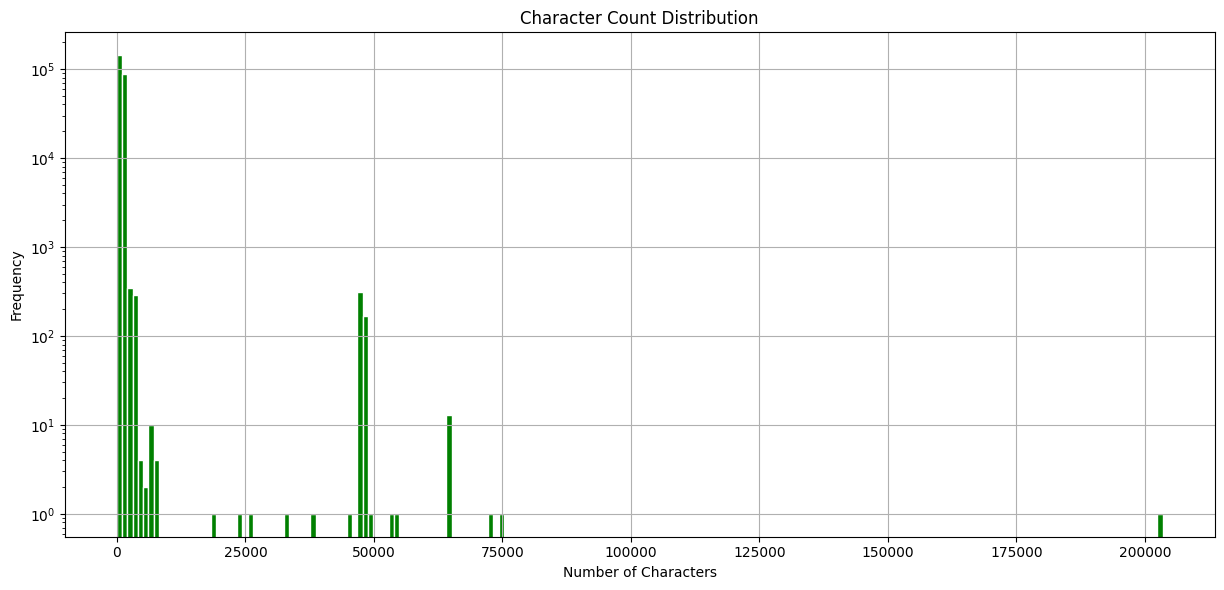

In [ ]:
#Extract the number of characters in each session as a feature
def count_characters(session): ## every character is counted, even the space ' ', this is why we used length
    return len(session)
data['num_characters'] = data['full_session'].apply(count_characters)

plt.figure(figsize=(24, 6))
plt.subplot(1, 2, 1)
plt.hist(data['num_characters'], bins=200, color='green',edgecolor='white')
plt.title('Character Count Distribution')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.yscale('log')
plt.tight_layout()
plt.grid()
plt.savefig('/content/drive/My Drive/ML_project/Character_Count_Distribution.png')
plt.show()

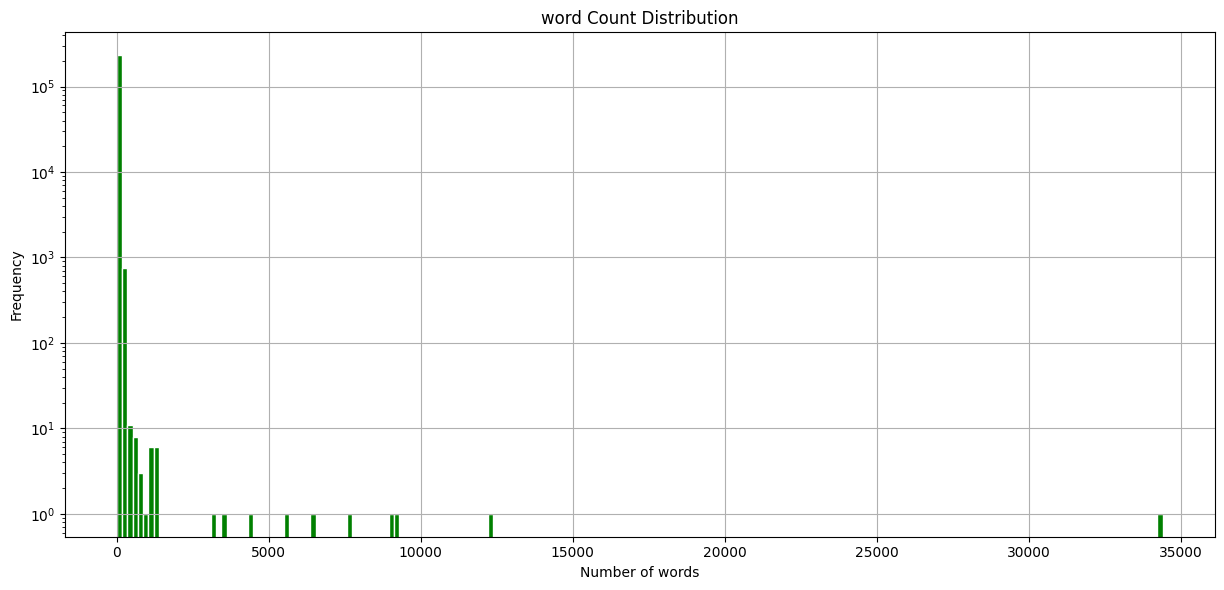

In [ ]:
#Extract the number of words in each session as a feature

data['Word_Count'] = data['full_session'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(24, 6))
plt.subplot(1, 2, 1)
plt.hist(data['Word_Count'], bins=200, color='green',edgecolor='white')
plt.title('word Count Distribution')
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.yscale('log')
plt.tight_layout()
plt.grid()
plt.savefig('/content/drive/My Drive/ML_project/word_count_distribution.png')
plt.show()

### **3. What are the most common words in the sessions?**

tmp: 1434324
grep: 1278495
var: 1207437
cat: 1082802
echo: 975347
proc: 656668
l: 640312
uname: 639145
name: 638991
cpuinfo: 638869


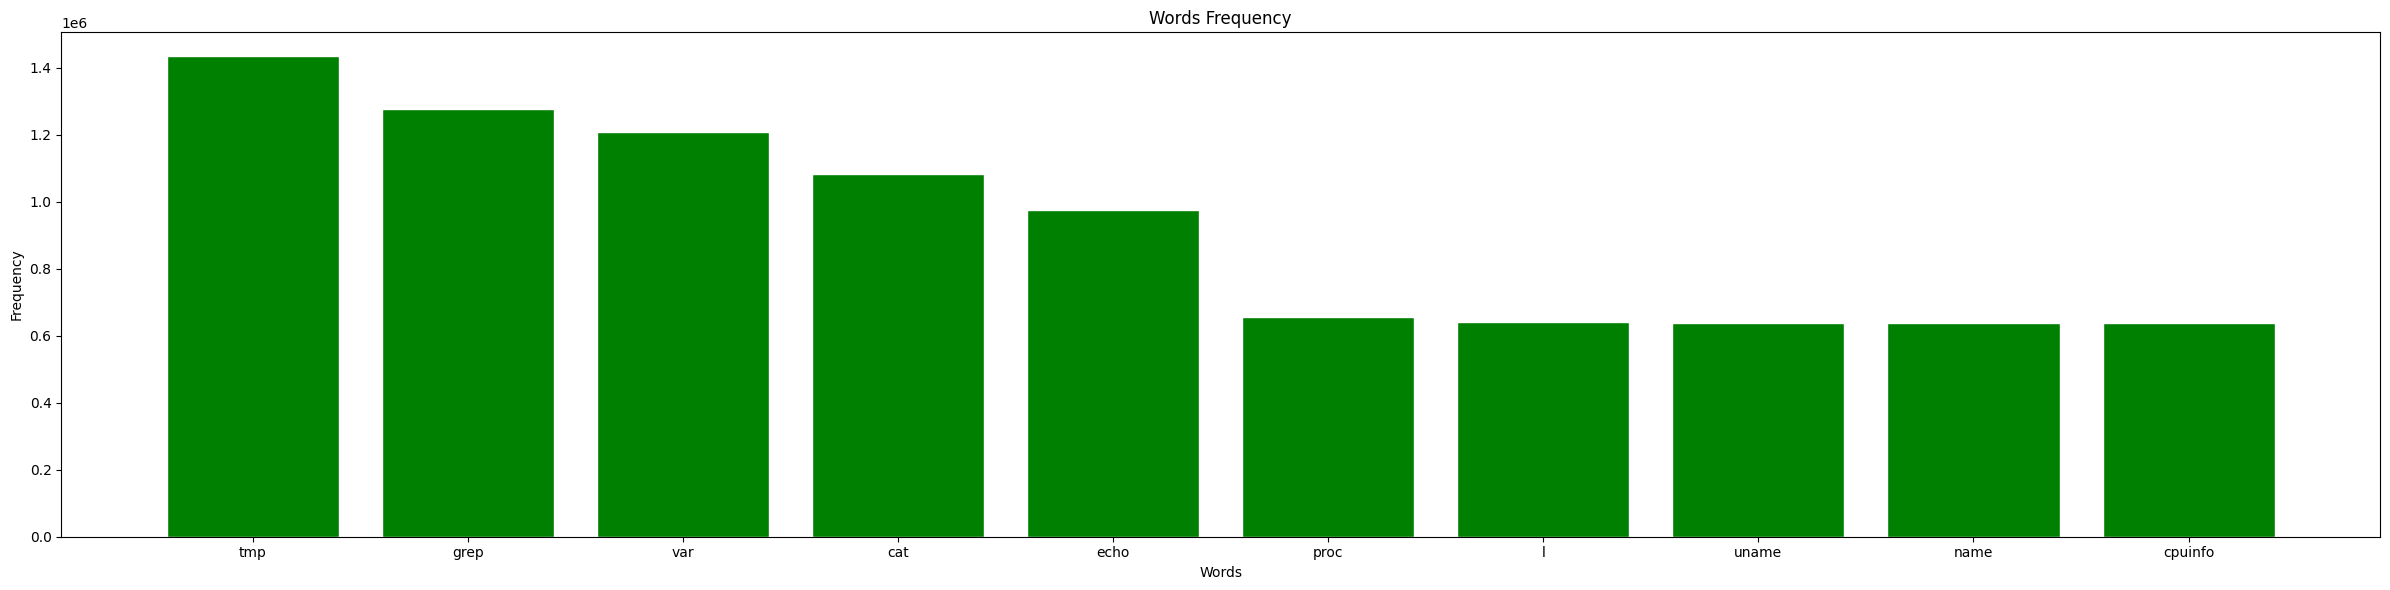

In [ ]:
# Most common words
def tokenize(text): #Tokenize the text and identify the most common words
    return re.findall(r'\w+', text)

all_tokens = [token for session in data['full_session'] for token in tokenize(session)] # we used tokens to count the no. of occurrences for each word

word_counts = Counter(all_tokens) # we stored each word with its no. of occerrence in the variable word_counts
most_common_words = word_counts.most_common(10) # we store only the most common 10 words in most_common_word

words =[]
counts=[]
for word, count in most_common_words:
    words.append(word)
    counts.append(count)
    print(f"{word}: {count}")

# Histogram for  number of words
plt.figure(figsize=(24, 6))
plt.bar(words,counts, color='green',edgecolor='white')
plt.title('Words Frequency')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('/content/drive/My Drive/ML_project/most_common_words.png')
plt.show()

### **4. How are the intents distributed? How many intents per session do you observe? What are the most common intents? How are the intents distributed in time?**

Most common intents:
Discovery: 232145
Persistence: 211295
Execution: 92927
Defense Evasion: 18999
Harmless: 2206
Other: 327
Impact: 27


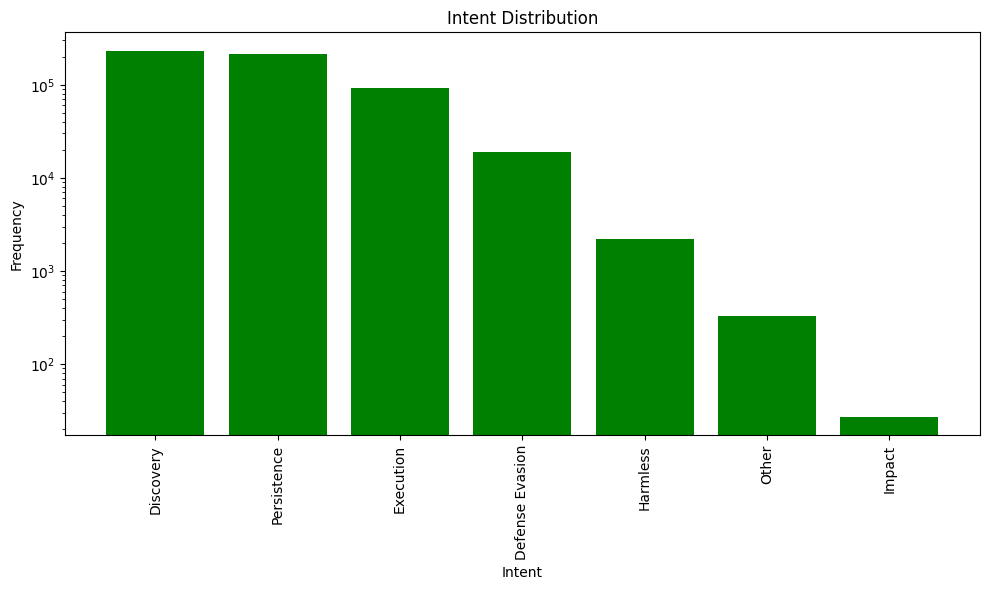

In [ ]:
#the number of intents per session
data['num_intents'] = data['Set_Fingerprint'].apply(len)

# Collect all intents and their occurrences
all_intents = [intent for session_intents in data['Set_Fingerprint'] for intent in session_intents]
intent_counts = Counter(all_intents)

#the most common intents
most_common_intents = intent_counts.most_common()


intents = []
counter = []

print("Most common intents:")
for intent, count in most_common_intents:
    print(f"{intent}: {count}")
    intents.append(intent)
    counter.append(count)

# Plot of frequency of each intent
plt.figure(figsize=(10, 6))
plt.bar(intents, counter, color='green')
plt.yscale('log')
plt.xlabel('Intent')
plt.ylabel('Frequency')
plt.title('Intent Distribution')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('/content/drive/My Drive/ML_project/most_common_intents.png')
plt.show()




In [ ]:
#How many intents per session do you observe?
data['num_intents']

0         2
1         2
2         2
3         2
4         2
         ..
233030    2
233031    2
233032    2
233033    2
233034    2
Name: num_intents, Length: 233035, dtype: int64

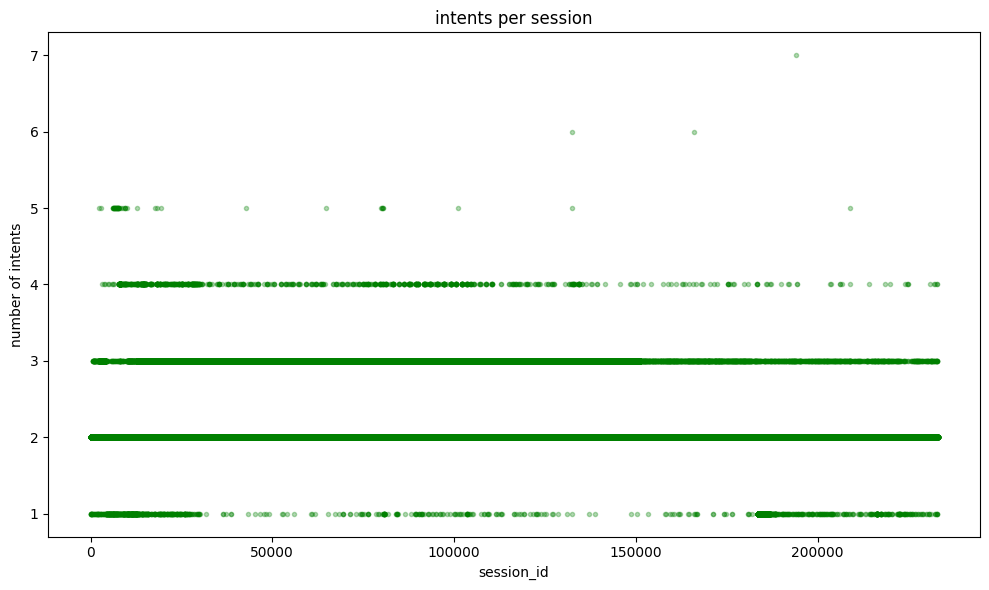

In [ ]:

# Convert data to numpy arrays
session_id = data['session_id'].values
num_intents = data['num_intents'].values

# Plot
plt.figure(figsize=(10, 6))
plt.plot(session_id, num_intents, color='green', linestyle= '', marker='.', alpha=0.3)

plt.xlabel('session_id')
plt.ylabel('number of intents')
plt.title('intents per session')

plt.tight_layout()
plt.savefig('/content/drive/My Drive/ML_project/intents_per_session.png')

plt.show()



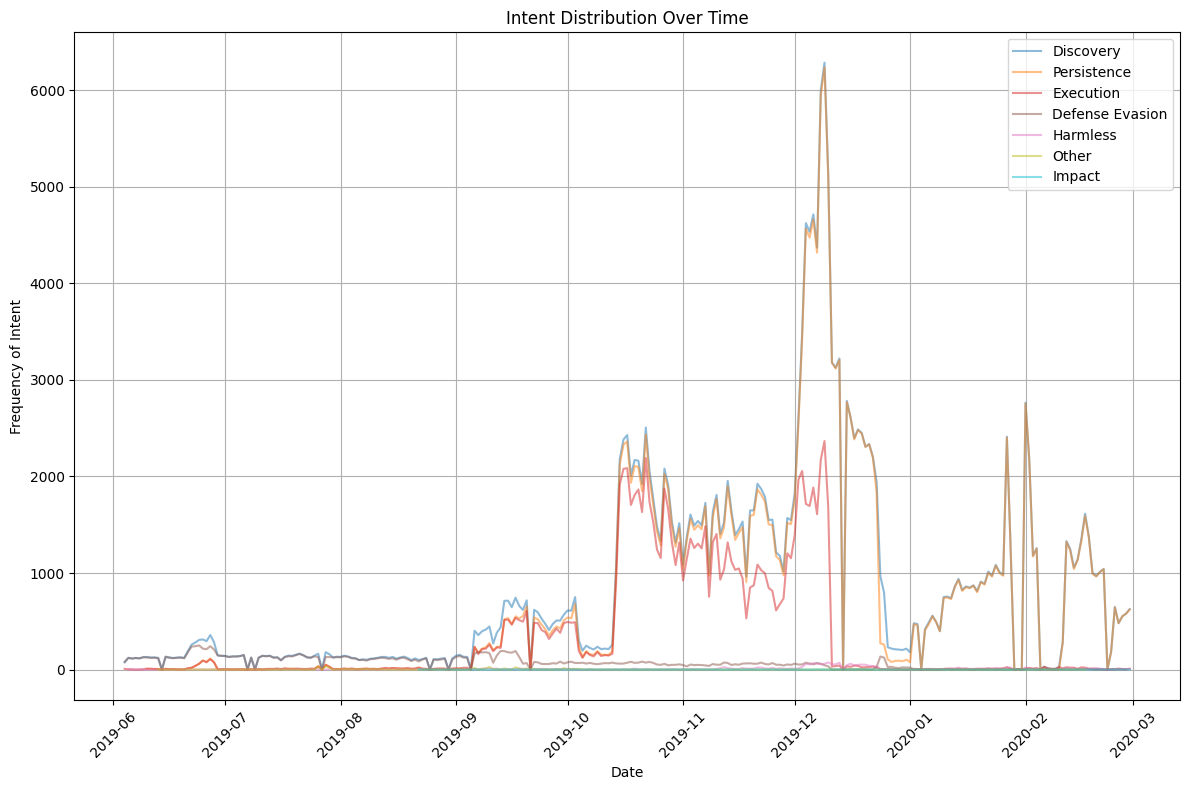

In [ ]:
data['first_timestamp'] = pd.to_datetime(data['first_timestamp'])

# Create a list of colors for each intent
colors = plt.cm.tab10(np.linspace(0, 1, len(most_common_intents)))


# Plotting all intents on the same plot

plt.figure(figsize=(12, 8))

for i, (intent, _) in enumerate(most_common_intents):
    intent_data = data[data['Set_Fingerprint'].apply(lambda x: intent in x)]
    intent_time_distribution = intent_data.resample('D', on='first_timestamp').size()

    plt.plot(intent_time_distribution.index.to_numpy(), intent_time_distribution.to_numpy(), label=intent, color=colors[i],alpha=0.5)

plt.xlabel('Date')
plt.ylabel('Frequency of Intent')
plt.title('Intent Distribution Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid()
plt.savefig('/content/drive/My Drive/ML_project/Distribution_over_time.png')
plt.show()

### **5. How can text represented numerically? Try to convert the text into numerical representations(vectors) through Bag of Words (BoW)**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import shlex


def safe_split(command):
    try:
        return shlex.split(command)
    except ValueError as e:
        if "No closing quotation" in str(e):
            command += '"'  # Add a closing quote to the end of the command
            # print(f"Fixed command: {command}")
            try:
                return shlex.split(command)
            except ValueError:
                # print(f"Error after fixing: {command}. Skipping...")
                return []
        else:
            # print(f"Error processing command: {command}. Skipping...")
            return []

commands_list=data['full_session']

# Step 1: Split commands using shlex
commands_list_split = [safe_split(command) for command in commands_list]
commands_list_split = [cmd for cmd in commands_list_split if cmd]  # Remove any empty lists


commands_flat = [' '.join(item) for item in commands_list_split]
vectorizer = CountVectorizer(token_pattern=r"[^\s;]+")
X = vectorizer.fit_transform(commands_flat)

In [ ]:
# Print out a portion of the sparse matrix
def print_sparse_matrix_portion(sparse_matrix, start_row, end_row):
    end_row = min(end_row, sparse_matrix.shape[0])

    dense_portion = sparse_matrix[start_row:end_row].toarray()

    print(dense_portion)

print_sparse_matrix_portion(X, 0, 20)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


### **6.Associate each word in each attack session with its TF-IDF value (Term Frequency-Inverse Document Frequency)**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import shlex
import re
import pandas as pd

# Safe split function to handle commands with unclosed quotes
def safe_split(command):
    try:
        return shlex.split(command)
    except ValueError as e:
        if "No closing quotation" in str(e):
            command += '"'
            try:
                return shlex.split(command)
            except ValueError:
                pass  # If it still fails, we skip this command
        return []


commands = data['full_session']
commands_list_split = [safe_split(command) for command in commands]
commands_flat = [' '.join(item) for item in commands_list_split]

# Function to preprocess stop words to match vectorizer's tokenization
def preprocess_stop_words(stop_words):
    processed = []
    for word in stop_words:
        word = word.lower()
        word = re.sub(r'[^\w\s]', '', word)  # Remove punctuation
        processed.append(word)
    return processed

# Custom stop words specific to Linux commands and common paths
custom_stop_words = [
    'ls', 'cd', 'echo', 'cat', 'chmod', 'sudo', 'grep', '-v', '-r',
    'root', '/home/user', 'tmp', 'var', 'name', 'proc', 'cpuinfo', 'l',
    '-l', 'wc', 'error', 'warning', '|', ';', 'bash'
]

# Preprocess the stop words
custom_stop_words = preprocess_stop_words(custom_stop_words)

# Create a TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(
    min_df=0.01,
    max_df=0.95,
    max_features=10000,
    stop_words=custom_stop_words
)

# Fit and transform the data to calculate TF-IDF
tfidf_matrix = tfidf_vectorizer.fit_transform(commands_flat)



In [ ]:
# Get feature names (words)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Create a DataFrame to associate each word with its TF-IDF value
tfidf_values = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

tf_idf_df = tfidf_matrix.toarray()
data['tf_idf'] = tf_idf_df.tolist()

print(data['tf_idf'])

0         [0.0, 0.0, 0.0, 0.0, 0.12857118194428388, 0.0,...
1         [0.0, 0.0, 0.0, 0.0, 0.12857118194428388, 0.0,...
2         [0.0, 0.0, 0.0, 0.0, 0.12857118194428388, 0.0,...
3         [0.0, 0.0, 0.0, 0.0, 0.12857118194428388, 0.0,...
4         [0.0, 0.0, 0.0, 0.0, 0.12857118194428388, 0.0,...
                                ...                        
233030    [0.0, 0.0, 0.0, 0.12876839485053337, 0.0, 0.0,...
233031    [0.0, 0.0, 0.0, 0.12876839485053337, 0.0, 0.0,...
233032    [0.0, 0.0, 0.0, 0.12876839485053337, 0.0, 0.0,...
233033    [0.0, 0.0, 0.0, 0.12876839485053337, 0.0, 0.0,...
233034    [0.0, 0.0, 0.0, 0.12876839485053337, 0.0, 0.0,...
Name: tf_idf, Length: 233035, dtype: object


In [ ]:
# Changing datetime to timestamp to be convenient to normalize or standardize it
data['first_timestamp'] = data['first_timestamp'].astype('int64') // 10**9
data['first_timestamp']

0         1559641511
1         1559641550
2         1559642081
3         1559643734
4         1559644639
             ...    
233030    1583020048
233031    1583020141
233032    1583020578
233033    1583020616
233034    1583020762
Name: first_timestamp, Length: 233035, dtype: int64

In [ ]:
#we save the results as an pickle file in order to use it in the other sections
import pickle


with open('/content/drive/My Drive/ML_project/shared_data.pkl', 'wb') as file:
    pickle.dump(data, file)


